# Soiaporn model

Prototype the Metropolis-within-Gibbs sampling technique presented in Soiaporn et al. 2012.

The full conditionals:

$$
F_T | f, \lambda, D \sim Gamma \bigg(N_C +1, \frac{1}{1/s + (1 - f)\epsilon_0 + f \sum_{k \geq 1} w_k \epsilon_k}\bigg)
$$

$$
P(\lambda_i | F_T, f, D) \propto \frac{f_{\lambda_i}}{\epsilon_{\lambda_i}} h_{\lambda_i}
$$

Where $h_{j} = (1 - f) \epsilon_0$ if $j = 0$ and $h_j = fw_j\epsilon_j$ if $j \geq 1$.

$$
P(f | \lambda, F_T, D) \propto e^{-F_T [  (1 - f)\epsilon_0  + f \sum_{k \geq 1} \epsilon_k w_k] } \times (1-f)^{m_0(\lambda) + b - 1}f^{N_C - m_0(\lambda)+a-1}
$$


$F_T$ and $\lambda$ are sampled directly from the gamma and multinomial distributions. $f$ is sampled using a random walk Metropolis algorithm with Gaussian proposals centred on the current value of $f$. The variance of the proposal distribution was tuned to give an acceptance rate of 25%.

$\kappa$ is treated specially, they consider a logarithmically spaced grid of values to condition on. So, treat $\kappa$ as fixed. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from fancy import Data
import pystan
from soiaporn_functions import *

## Set up

In [3]:
# choose initial values
kappa = 100
kappa_c = 1000
F_T = 0.2 
f = 0.5

alpha_T = 20370
M = 7.42

# hyperparametrs
a = 1
b = a
s = 0.01 * 4 * np.pi

In [4]:
# load data
uhecr_file = '../uhecr_model/data/auger_UHECR_list.dat'
source_file = 'data/agn_catalog.dat'

data = Data()
data.add_source(source_file, 'AGN')
data.add_uhecr(uhecr_file, 'Auger2010')

N_C = len(data.uhecr.energy)

In [5]:
# integral tables
sim_table = 'data/tablekappa100.data.R'
eps = pystan.read_rdump(sim_table)['table'][0]

eps = eps * alpha_T / M

In [6]:
# weights
w = get_weights(data.source.distance)

In [7]:
theta = np.deg2rad(data.uhecr.incidence_angle)
d = data.uhecr.unit_vector
varpi = data.source.unit_vector

## Sampler

In [8]:
# initialise 
accept_count = 0
F_T_list = []
f_list = []

for i in range(5000):
    # F_T
    F_T = np.random.gamma(N_C + 1, scale_F_T(s, f, eps, w))
    F_T_list.append(F_T)
    
    # lambda
    lam = []
    for i in range(N_C):
        p = get_p_lam(f, eps, kappa, kappa_c, d[i], theta[i], varpi, w)
        sample = np.asarray(np.random.multinomial(1, p))
        lam.append(np.where(sample == 1)[0][0])

    # f 
    f_new = np.random.normal(f, 0.2)
    while (f_new < 0):
        f_new = np.random.normal(f, 0.2)
    p_f_old = log_p_f(F_T, f, eps, lam, w, N_C, a, b)
    p_f_new = log_p_f(F_T, f_new, eps, lam, w, N_C, a, b)
    if(p_f_new > p_f_old):
        f = f_new
        accept_count += 1
    else:
        accept_ratio = np.exp(p_f_new - p_f_old)
        check = np.random.uniform(0, 1)
        if check <= accept_ratio:
            f = f_new
            accept_count += 1
        else:
            f = f
    f_list.append(f)

In [9]:
print(sum(p))
print(accept_count/5000)

1.0
0.1922


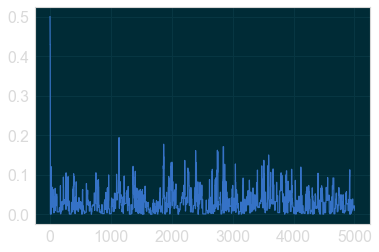

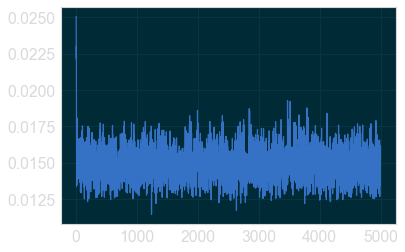

In [10]:
plt.figure()
plt.plot(f_list)
plt.figure()
plt.plot(F_T_list)

(array([4.073e+03, 7.470e+02, 1.530e+02, 2.300e+01, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00]),
 array([3.91058622e-05, 5.00351953e-02, 1.00031285e-01, 1.50027374e-01,
        2.00023464e-01, 2.50019553e-01, 3.00015642e-01, 3.50011732e-01,
        4.00007821e-01, 4.50003911e-01, 5.00000000e-01]),
 <a list of 10 Patch objects>)

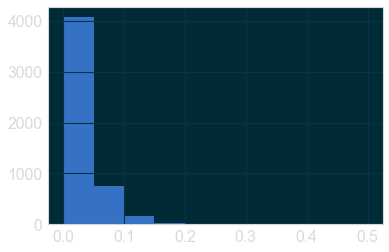

In [11]:
plt.hist(f_list)